<a href="https://colab.research.google.com/github/krislars/DustTools/blob/main/BDBS_extinction_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks shows how to use the BDBS extinction map from Iulia Simion when the map is stored on the user's Google Drive.  Contact the BDBS team for access to the map.  Here I make a map for NGC 6563.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy import units as u
# from astropy import wcs
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from scipy.ndimage import map_coordinates

In [2]:
# generic start:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
# path specifically for my drive:
%cd MyDrive
%cd 'Colab Notebooks'

Mounted at /gdrive
/gdrive
/gdrive/MyDrive
/gdrive/MyDrive/Colab Notebooks


## Test by showing entire map

In [3]:
# dustmapfn='extmap_bulge.fits'
dustmapfn='BDBS_ext/extmap_bulge.fits' # also specific to Kristen
hdulist=fits.open(dustmapfn)
mapds=[hdulist[0].data]
# Parse the WCS keywords in the primary HDU
w = WCS(hdulist[0].header)

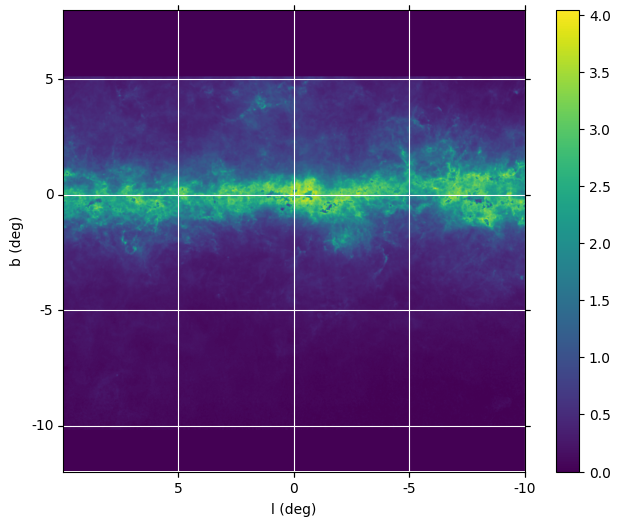

In [4]:
plt.figure(figsize=(8,6))
ax = plt.subplot(projection=w)
for mapd in mapds:
    plt.imshow(mapd, vmin=0, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('l (deg)')
plt.ylabel('b (deg)')
plt.colorbar();

Compare with [Figure 1](https://academic.oup.com/view-large/figure/95521686/stx1832fig1.jpg)
from [Simion et al (2017)](https://academic.oup.com/mnras/article/471/4/4323/3980211)


## Single position

In [5]:
c = SkyCoord.from_name('NGC 6569',frame='galactic')
c

<SkyCoord (Galactic): (l, b) in deg
    (0.48143959, -6.68095092)>

In [6]:
# Convert the data (l, b) to pixel coordinates. l and b are float arrays
pixx, pixy = w.wcs_world2pix(c.l, c.b, 1)

#Read the extinction value
for mapd in mapds:
    ext = map_coordinates(mapd, [[pixy],[pixx]], order=0) # note y,x order

    #transform from VVV to 2MASS (the map is for VVV photometry)
    ext2m = 1.0/0.925*ext[0]

    #2MASS to EBV using the equations in Green+ 2018
    ebv2 = ext2m/0.489

#Green et al. 2018
Ag = 3.384*ebv2
Ar = 2.483*ebv2
Ai =  1.838*ebv2
Az =  1.414*ebv2
Ay = 1.126*ebv2
Au =  4.239*ebv2 #from Schlafly+ 2011
print('Au Ag Ar Ai Az Ay = ',round(Au,3),round(Ag,3),round(Ar,3),round(Ai,3),round(Az,3),round(Ay,3))

Au Ag Ar Ai Az Ay =  1.714 1.368 1.004 0.743 0.572 0.455


## Map: Coordinate array

In [28]:
name = 'NGC 6569'
c = SkyCoord.from_name(name,frame='galactic')
s = 1.0 # size in degrees
r = 1.0/60.0 # resolution in degrees

To Do: fix the cos(dec) projection

In [29]:
l_arr = np.flip(np.arange(c.l.deg-s/2,c.l.deg+s/2,r) * u.deg) # note order
b_arr = np.arange(c.b.deg-s/2,c.b.deg+s/2,r) * u.deg
lgrid,bgrid = np.meshgrid(l_arr,b_arr)

In [30]:
# Convert the data (l, b) to pixel coordinates. l and b are float arrays
pixx, pixy = w.wcs_world2pix(lgrid, bgrid, 1)

#Read the extinction value
for mapd in mapds:
    ext = map_coordinates(mapd, [[pixy],[pixx]], order=0)

    #transform from VVV to 2MASS (the map is for VVV photometry)
    ext2m = 1.0/0.925*ext[0]

    #2MASS to EBV using the equations in Green+ 2018
    ebv2 = ext2m/0.489

#Green et al. 2018
Ag = 3.384*ebv2

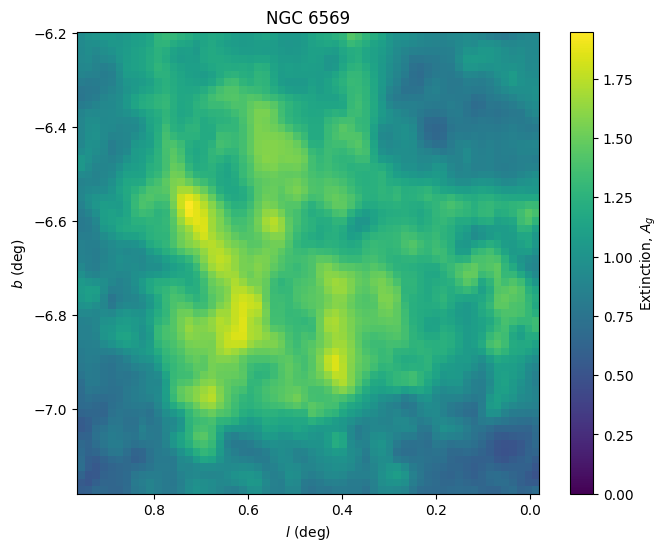

In [31]:
plt.figure(figsize=(8,6))
plt.imshow(Ag,origin='lower',vmin=0,
           extent=[l_arr.value.max(),l_arr.value.min(), # note order
                   b_arr.value.min(),b_arr.value.max()])
plt.xlabel('$l$ (deg)')
plt.ylabel('$b$ (deg)')
plt.title(name)
plt.colorbar(label='Extinction, $A_g$');

Repeat for equatorial coordinates:

In [64]:
c = SkyCoord.from_name(name,frame='icrs')
s = 1.0 # size in degrees
r = 1.0/120.0 # resolution in degrees

In [65]:
ra_arr = np.flip(np.arange(c.ra.deg-s/2,c.ra.deg+s/2,r) * u.deg) # note order
dec_arr = np.arange(c.dec.deg-s/2,c.dec.deg+s/2,r) * u.deg
ragrid,decgrid = np.meshgrid(ra_arr,dec_arr)

In [68]:
# return RA,Dec grid back to l,b in order to more easily access map
cgrid = SkyCoord(ragrid, decgrid, frame='icrs', unit='deg')
cgrid_lb = cgrid.transform_to('galactic')
# switch last longitude quadrant to negative
cgrid_lb.l.wrap_at('180d', inplace=True)

In [69]:
# Convert the data coords to pixel coordinates.
pixx, pixy = w.wcs_world2pix(cgrid_lb.l, cgrid_lb.b, 1)
#Read the extinction value
for mapd in mapds:
    ext = map_coordinates(mapd, [[pixy],[pixx]], order=0)
    #transform from VVV to 2MASS (the map is for VVV photometry)
    ext2m = 1.0/0.925*ext[0]
    #2MASS to EBV using the equations in Green+ 2018
    ebv2 = ext2m/0.489
#Green et al. 2018
Ag = 3.384*ebv2

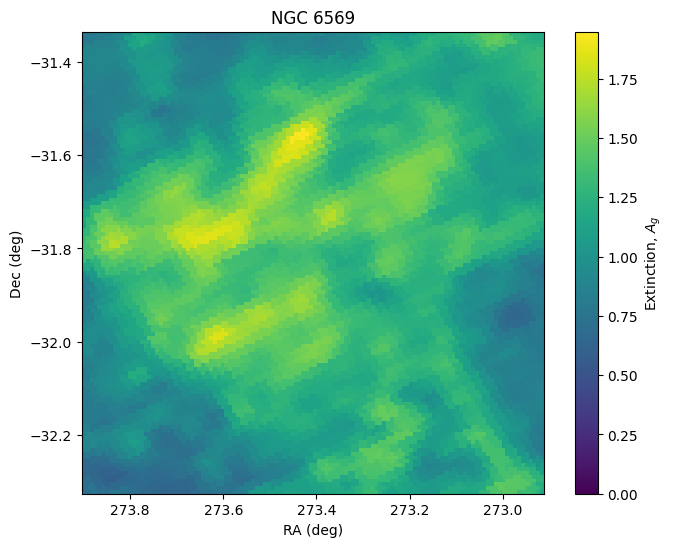

In [70]:
plt.figure(figsize=(8,6))
plt.imshow(Ag,origin='lower',vmin=0,
           extent=[ra_arr.value.max(),ra_arr.value.min(), # note order
                   dec_arr.value.min(),dec_arr.value.max()])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title(name)
plt.colorbar(label='Extinction, $A_g$');